<a href="https://colab.research.google.com/github/Mjoe00/Behaviour-Intention-Gap/blob/PortingInCode/Gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pickle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sn
import re
import xlwt
from xlwt import Workbook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
f=open('/content/gdrive/MyDrive/Colab Notebooks/app_data_sept.pkl','rb')
data=pickle.load(f)

# Exploring the data: sleep and the behaviour intention gap

In [ ]:
#extracting the dates
end = np.array(data['SurveyQuestionResults']['EndDate'])
realDate = np.copy(end)
tmp = ""
#setting the cutoff to 4:30am
cutoff = datetime.datetime.strptime("043000", "%H%M%S")

#looping to extract dates/times and convert them into manipuable numbers
for i in range (len(end)):
  if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
    if (int(realDate[i][8:10])-1) < 11:
      tmp = "0" + str((int(realDate[i][8:10])-1))
      realDate[i] = realDate[i][:8] + tmp
    else:
      realDate[i] = realDate[i][:8] + str((int(realDate[i][8:10])-1))
  else:
    realDate[i] = end[i][0:10]

data['SurveyQuestionResults']['Date'] = realDate


0.02907556448994089


Text(0.5, 1.0, 'Reported Sleep and Reported Intention Gap Over Time')

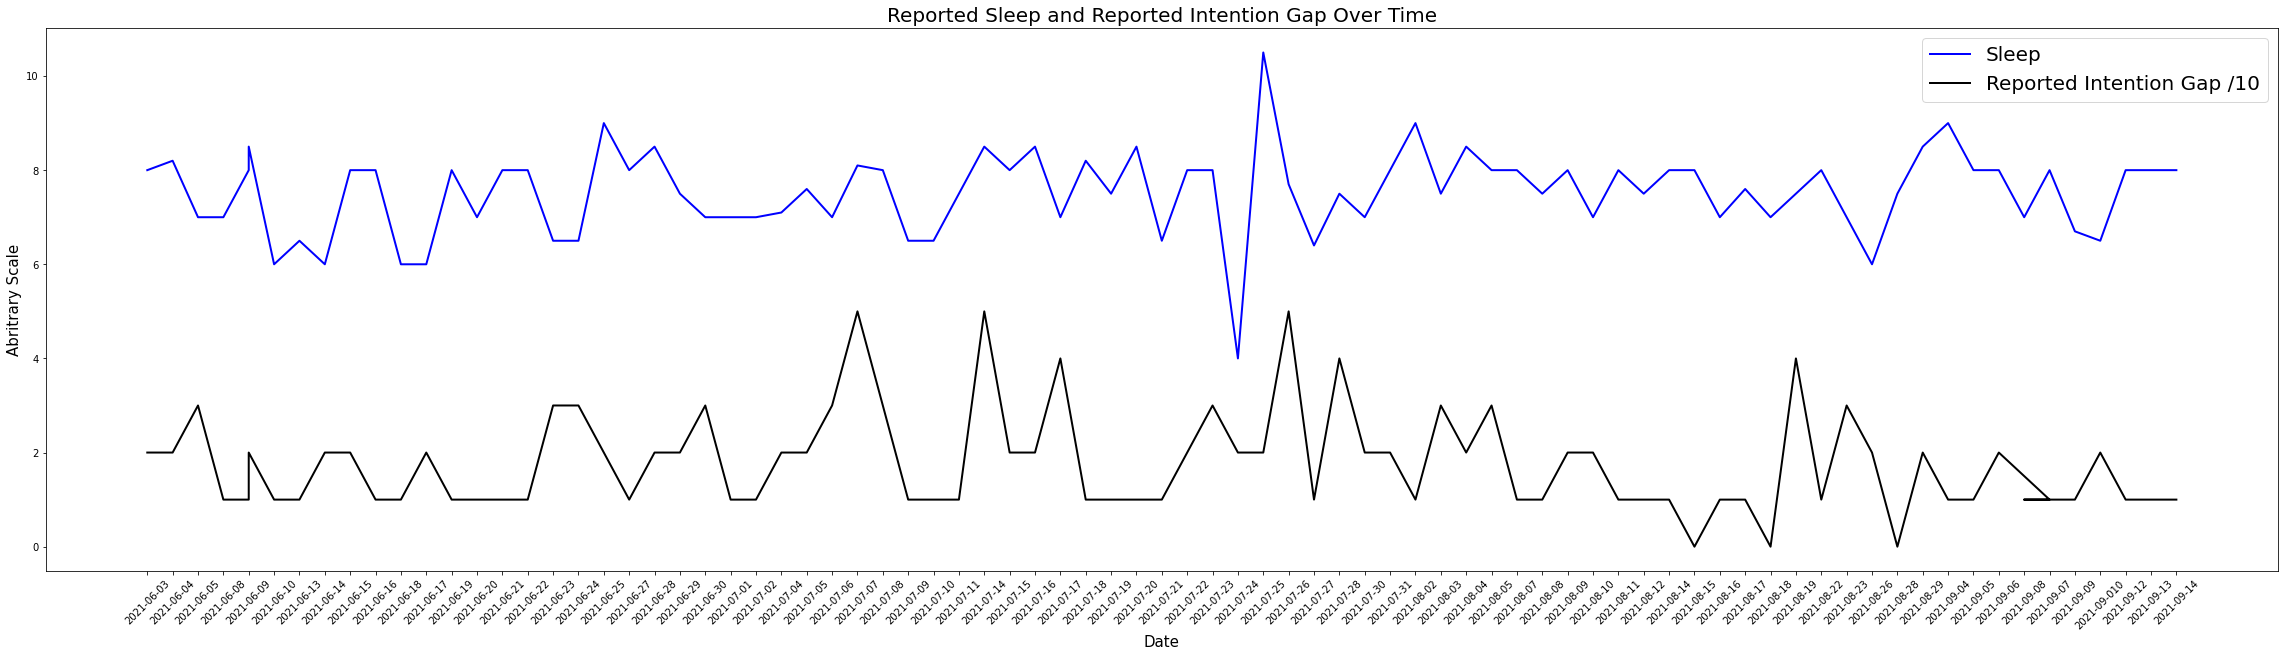

In [ ]:
#initializing the variables and extracting the sleep and gap data by participant id
sleepScore = []
gapScore = []
sleepDate = []
gapDate = []
raw = data['SurveyQuestionResults']['ResultIdentifier']
n = len(raw)
for i in range(n):
  if data['SurveyQuestionResults']['ParticipantIdentifier'][i] == 'ff6860f4-c110-4545-9297-95f8888d2e03':
    if raw[i] == 'DAILY_specific_past24_sleep':
      sleepScore.append(float(data['SurveyQuestionResults']['Answers'][i]))
      sleepDate.append(data['SurveyQuestionResults']['Date'][i])
    elif raw[i] == 'DAILY_global_past24_gap':
      gapScore.append(float(data['SurveyQuestionResults']['Answers'][i])/10)
      gapDate.append(data['SurveyQuestionResults']['Date'][i])

correlationS, p_value = pearsonr(sleepScore, gapScore)

print(correlationS)
#plotting the relationships
fig,ax = plt.subplots(1 ,figsize=(40,10))
ax.plot(sleepDate[::-1],sleepScore[::-1],'b-',linewidth=2,label='Sleep')
ax.plot(gapDate[::-1],gapScore[::-1],'k-',linewidth=2,label='Reported Intention Gap /10')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Abritrary Scale',fontsize=15)
ax.legend(fontsize=20)
ax.set_title('Reported Sleep and Reported Intention Gap Over Time',fontsize=20)

Text(0.5, 1.0, 'Reported Sleep and Reported Intention Gap Over Time')

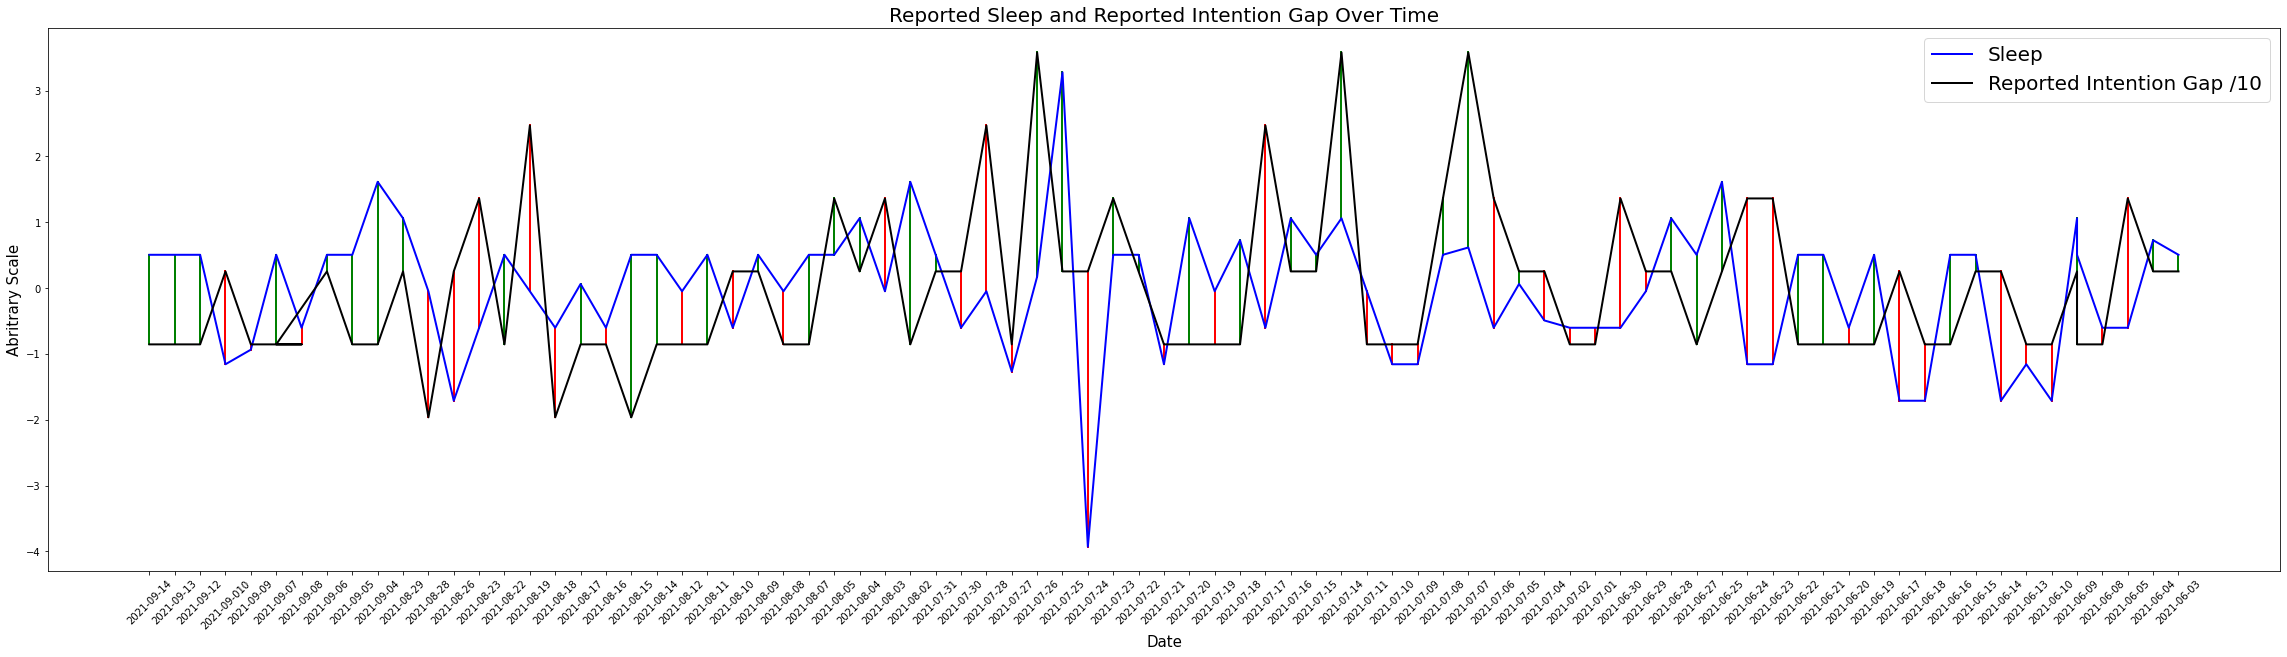

In [ ]:
meanSleep = np.mean(sleepScore)
meanGap = np.mean(gapScore)
stdSleep = np.std(sleepScore)
stdGap = np.std(sleepScore)
snooze = sleepScore.copy()
gapCopy = gapScore.copy()

difference = []
fig,ax = plt.subplots(1 ,figsize=(40,10))
for i in range(len(snooze)):
  snooze[i] = (snooze[i]-meanSleep)/stdSleep
  gapCopy[i] = (gapCopy[i]-meanGap)/stdGap
  if snooze[i] > 0:
    ax.plot((sleepDate[i],sleepDate[i]),(snooze[i],gapCopy[i]),'g-',linewidth=2)
  if snooze[i] < 0:
    ax.plot((sleepDate[i],sleepDate[i]),(snooze[i],gapCopy[i]),'r-',linewidth=2)

#plotting the relationships
ax.plot(sleepDate[::-1],snooze[::-1],'b-',linewidth=2,label='Sleep')
#ax.plot(sleepDate[::-1],difference[::-1],'g-',linewidth=2,label='difference')
ax.plot(gapDate[::-1],gapCopy[::-1],'k-',linewidth=2,label='Reported Intention Gap /10')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Abritrary Scale',fontsize=15)
ax.legend(fontsize=20)
ax.set_title('Reported Sleep and Reported Intention Gap Over Time',fontsize=20)

# Exploring the data: comparing current to previous day (does not account for missed days)




In [ ]:
#initializing some variables and a dictionary
DailyGoals={'DAILY_specific_past24_sleep':[],
 'DAILY_specific_past24_jobSchool':[],
 'DAILY_specific_past24_unpaidWork':[],
 'DAILY_specific_past24_leisureSolo':[],
 'DAILY_specific_past24_leisureNonSolo':[],
 'DAILY_specific_past24_exercise':[],
 'DAILY_specific_past24_drinks':[],
 'DAILY_specific_next24_sleep':[],
 'DAILY_specific_next24_jobSchool':[],
 'DAILY_specific_next24_unpaidWork':[],
 'DAILY_specific_next24_leisureSolo':[],
 'DAILY_specific_next24_leisureNonSolo':[],
 'DAILY_specific_next24_exercise':[],
 'DAILY_specific_next24_drinks':[]
    
}
#this variable will be used for indexing
GoalsIdentifier = []


In [ ]:
#looping to extract the result keys for easier indexing later
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  if data['SurveyQuestionResults']['SurveyResultKey'][i] == "3d37a112-db15-ec11-aab0-0afb9334277d" and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
    GoalsIdentifier.append(data['SurveyQuestionResults']['ResultIdentifier'][i])
    
SetGoalsIdentifier = GoalsIdentifier[14:]
GoalsIdentifier = GoalsIdentifier[:14]
SetGoalsIdentifier

['DAILY_goal_report1',
 'DAILY_goal_report2',
 'DAILY_goal_set1',
 'DAILY_goal_set1_importance',
 'DAILY_goal_set1_consequences',
 'DAILY_goal_set1_motivationInternal',
 'DAILY_goal_set1_motivationExternal',
 'DAILY_goal_set2',
 'DAILY_goal_set2_importance',
 'DAILY_goal_set2_consequences',
 'DAILY_goal_set2_motivationInternal',
 'DAILY_goal_set2_motivationExternal']

In [ ]:
#looping to exract all the specific data points and sorting them into their respective key
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'][:14500])):
  for j in range(len(GoalsIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == GoalsIdentifier[j] and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
      DailyGoals[GoalsIdentifier[j]].append(float(data['SurveyQuestionResults']['Answers'][i]))

#checking the length of each to make sure there is no missing data
for j in range(len(GoalsIdentifier)):
  print(len(DailyGoals[GoalsIdentifier[j]]))
  print(GoalsIdentifier[j])



83
DAILY_specific_past24_sleep
83
DAILY_specific_past24_jobSchool
83
DAILY_specific_past24_unpaidWork
83
DAILY_specific_past24_leisureSolo
83
DAILY_specific_past24_leisureNonSolo
83
DAILY_specific_past24_exercise
83
DAILY_specific_past24_drinks
83
DAILY_specific_next24_sleep
83
DAILY_specific_next24_jobSchool
83
DAILY_specific_next24_unpaidWork
83
DAILY_specific_next24_leisureSolo
83
DAILY_specific_next24_leisureNonSolo
83
DAILY_specific_next24_exercise
83
DAILY_specific_next24_drinks


In [ ]:
#trimming the first inputed pervious goals as they might intervene(this is wrong, i am neglecting other peoples stuff)
for x in range(len(GoalsIdentifier)-7):
  DailyGoals[GoalsIdentifier[x]] = DailyGoals[GoalsIdentifier[x]][:-1]

#trimming the last inputed next goals as they are inimportant(also wrong)
for x in range(len(GoalsIdentifier)-7):
  DailyGoals[GoalsIdentifier[x+7]] = DailyGoals[GoalsIdentifier[x+7]][1:]

In [ ]:
#checking the length again to confirm they have been deleted correctly
for j in range(len(GoalsIdentifier)):
  print(len(DailyGoals[GoalsIdentifier[j]]))
  print(GoalsIdentifier[j])

82
DAILY_specific_past24_sleep
82
DAILY_specific_past24_jobSchool
82
DAILY_specific_past24_unpaidWork
82
DAILY_specific_past24_leisureSolo
82
DAILY_specific_past24_leisureNonSolo
82
DAILY_specific_past24_exercise
82
DAILY_specific_past24_drinks
82
DAILY_specific_next24_sleep
82
DAILY_specific_next24_jobSchool
82
DAILY_specific_next24_unpaidWork
82
DAILY_specific_next24_leisureSolo
82
DAILY_specific_next24_leisureNonSolo
82
DAILY_specific_next24_exercise
82
DAILY_specific_next24_drinks


In [ ]:
#initializing percent arrays
PercentSleep = []
PercentjobSchool = []
PercentunpaidWork = []
PercentleisureSolo = []
PercentleisureNonSolo = []
Percentexercise = []
Percentdrinks = []


#converting the data into percentage goals
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_sleep'], DailyGoals['DAILY_specific_next24_sleep']):
    PercentSleep.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_jobSchool'], DailyGoals['DAILY_specific_next24_jobSchool']):
    PercentjobSchool.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_unpaidWork'], DailyGoals['DAILY_specific_next24_unpaidWork']):
    PercentunpaidWork.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_leisureSolo'], DailyGoals['DAILY_specific_next24_leisureSolo']):
    PercentleisureSolo.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_leisureNonSolo'], DailyGoals['DAILY_specific_next24_leisureNonSolo']):
    PercentleisureNonSolo.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_exercise'], DailyGoals['DAILY_specific_next24_exercise']):
    Percentexercise.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_drinks'], DailyGoals['DAILY_specific_next24_drinks']):
    Percentdrinks.append(np.divide(prev,next,where=next>0)*100)



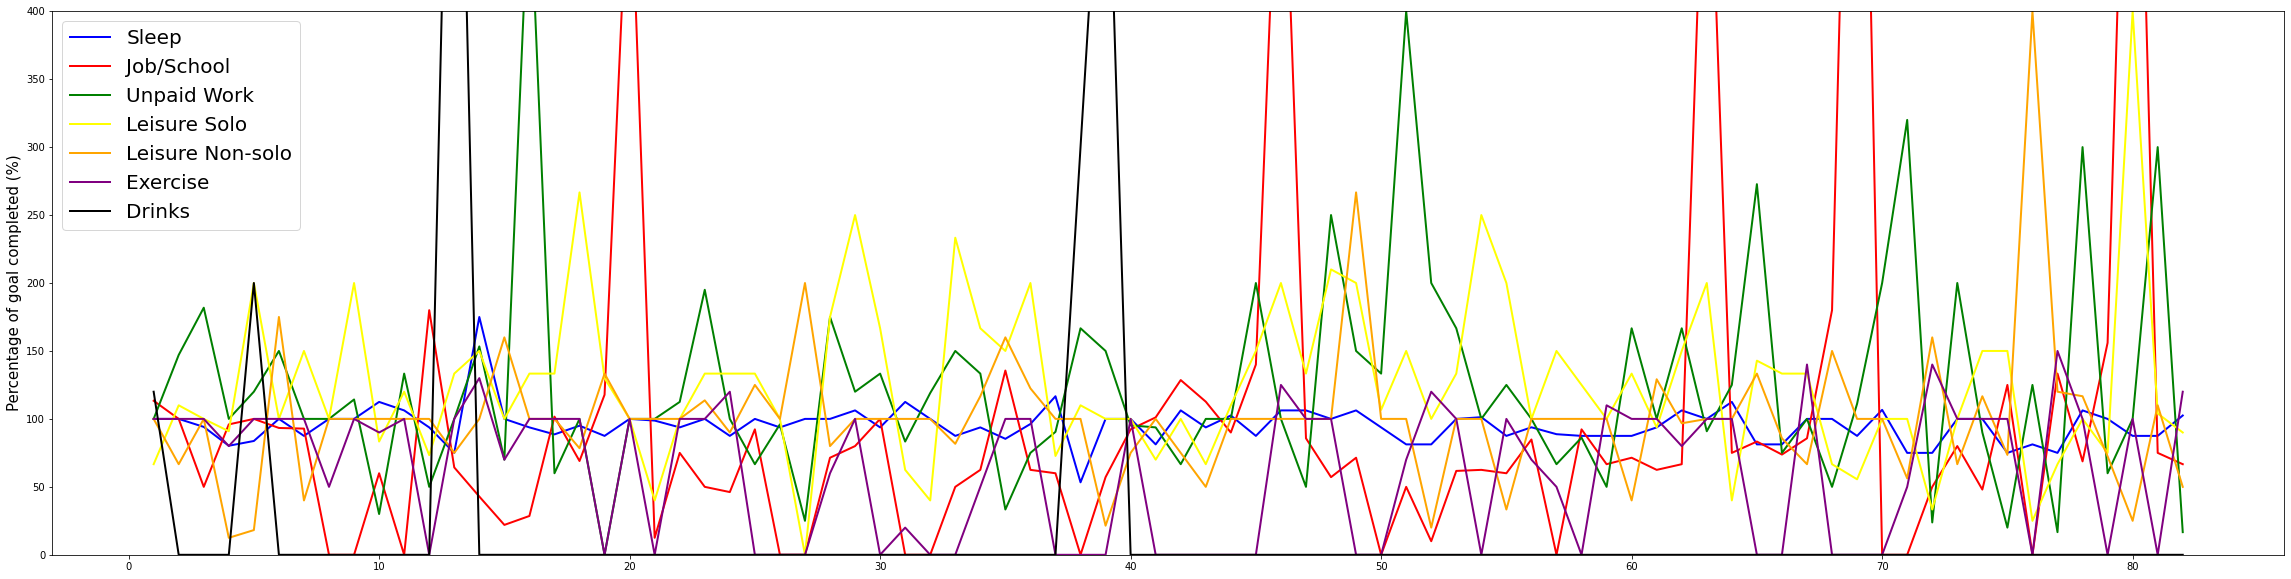

In [ ]:
#plotting the data
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = list(range(1,len(PercentSleep)+1))
ax.plot(x, PercentSleep,color="blue",linewidth=2,label='Sleep')
ax.plot(x, PercentjobSchool,color="red",linewidth=2,label='Job/School')
ax.plot(x, PercentunpaidWork,color="green",linewidth=2,label='Unpaid Work')
ax.plot(x, PercentleisureSolo,color="yellow",linewidth=2,label='Leisure Solo')
ax.plot(x, PercentleisureNonSolo,color="orange",linewidth=2,label='Leisure Non-solo')
ax.plot(x, Percentexercise,color="purple",linewidth=2,label='Exercise')
ax.plot(x, Percentdrinks,color="black",linewidth=2,label='Drinks')
ax.set_ylabel('Percentage of goal completed (%)',fontsize=15)
ax.set_ylim(0,400)
ax.legend(fontsize=20)

# Exploring the data: the difference between the two daily goals and the self perceived gap (the next step should be to examine the intentions for the preset goals)

In [ ]:
#initializing variables to get daily goal info
OtherDailyGoals={'DAILY_goal_report1':[],
 'DAILY_goal_report2':[],
 'DAILY_goal_set1':[],
 'DAILY_goal_set1_importance':[],
 'DAILY_goal_set1_consequences':[],
 'DAILY_goal_set1_motivationInternal':[],
 'DAILY_goal_set1_motivationExternal':[],
 'DAILY_goal_set2':[],
 'DAILY_goal_set2_importance':[],
 'DAILY_goal_set2_consequences':[],
 'DAILY_goal_set2_motivationInternal':[],
 'DAILY_goal_set2_motivationExternal':[]
    
}
#looping to extract the goal data into the initialized dictionary, but only for my own data
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'][:15500])):
  for j in range(len(SetGoalsIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == SetGoalsIdentifier[j] and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
      if len(data['SurveyQuestionResults']['Answers'][i]) > 3:
        OtherDailyGoals[SetGoalsIdentifier[j]].append(data['SurveyQuestionResults']['Answers'][i])
      else:
        OtherDailyGoals[SetGoalsIdentifier[j]].append(float(data['SurveyQuestionResults']['Answers'][i]))

#checking the length of each to make sure there is no missing data
for j in range(len(SetGoalsIdentifier)):
  print(len(OtherDailyGoals[SetGoalsIdentifier[j]]))
  print(SetGoalsIdentifier[j])

83
DAILY_goal_report1
83
DAILY_goal_report2
83
DAILY_goal_set1
83
DAILY_goal_set1_importance
83
DAILY_goal_set1_consequences
83
DAILY_goal_set1_motivationInternal
83
DAILY_goal_set1_motivationExternal
83
DAILY_goal_set2
83
DAILY_goal_set2_importance
83
DAILY_goal_set2_consequences
83
DAILY_goal_set2_motivationInternal
83
DAILY_goal_set2_motivationExternal


In [ ]:
#trimming the first inputed pervious goals as they might intervene(this is wrong, i am neglecting other peoples stuff buts its fine because its isolating my own goals)

OtherDailyGoals['DAILY_goal_report1'] = OtherDailyGoals['DAILY_goal_report1'][:-1]
OtherDailyGoals['DAILY_goal_report2'] = OtherDailyGoals['DAILY_goal_report2'][:-1]

#trimming the last inputed next goals as they are inimportant(also wrong)
for x in SetGoalsIdentifier[2:]:
  OtherDailyGoals[x] = OtherDailyGoals[x][1:]

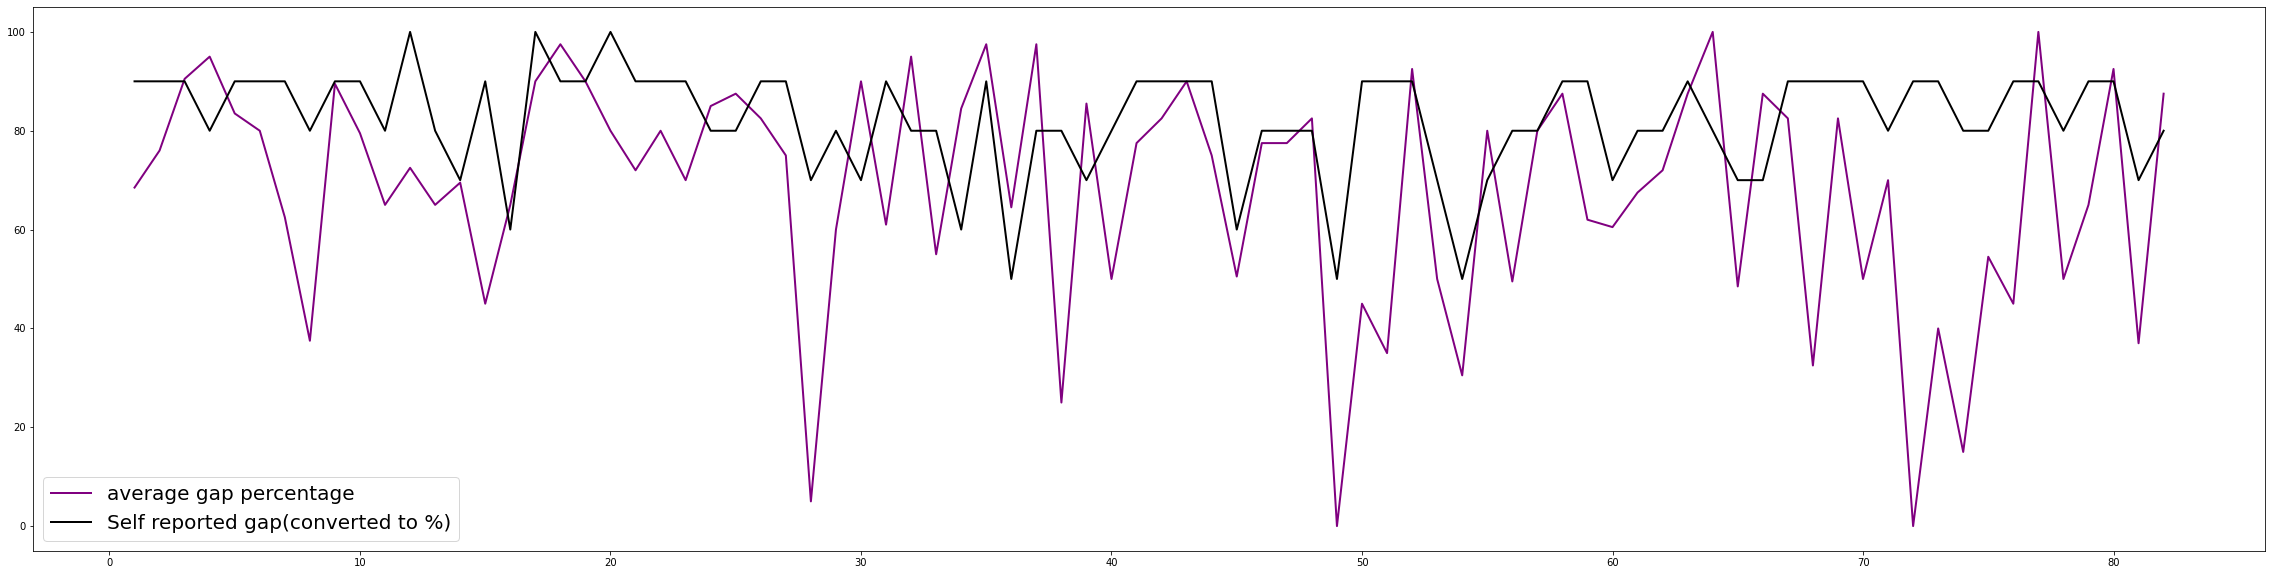

In [ ]:
#reverse coding the gap score and making it fit a percentage scale
SPgap = []
for i in gapScore:
  SPgap.append(100-(i*10))

#creating an average BI score for the two goals set each day
averageGap = []
for i in range(len(OtherDailyGoals['DAILY_goal_report1'])):
  averageGap.append((OtherDailyGoals['DAILY_goal_report1'][i] + OtherDailyGoals['DAILY_goal_report2'][i])/2)


#plotting the different gap scores against eachother
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = list(range(1,len(OtherDailyGoals['DAILY_goal_report1'])+1))
#ax.plot(x, OtherDailyGoals['DAILY_goal_report1'],color="blue",linewidth=2,label='Goal 1 percentage')
#ax.plot(x, OtherDailyGoals['DAILY_goal_report2'],color="red",linewidth=2,label='Goal 2 percentage')
ax.plot(x, averageGap,color="purple",linewidth=2,label='average gap percentage')
ax.plot(x, SPgap[:-1],color="black",linewidth=2,label='Self reported gap(converted to %)')
ax.set_ylim(-5,105)
ax.legend(fontsize=20)

# Exploring the data: creating a function to test pearsons r correlations of survey results and percieved gap measure

In [ ]:
#creating a function to test pearsons r correlations of survey results and percieved gap measure
def CorrelationR(aff,id):
  AffectMeasure = []
  Gap = []

  for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == aff and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == id:
      AffectMeasure.append(float(data['SurveyQuestionResults']['Answers'][i]))
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == 'DAILY_global_past24_gap' and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == id:
      Gap.append(float(data['SurveyQuestionResults']['Answers'][i]))
  correlation, p_value = pearsonr(AffectMeasure, Gap)

  print(correlation)

In [ ]:
CorrelationR(score,'ff6860f4-c110-4545-9297-95f8888d2e03')
#'ff6860f4-c110-4545-9297-95f8888d2e03'
#'229876e0-c6b0-42b7-9d83-85f07f12eb05'



NameError: ignored

# Exploring the data: Creating a heatmap of all the affect variables to examine interesting correlations

In [ ]:
#initializing some variables and a dictionary
Affects={'affect_neg_frustrated':[],
 'affect_pos_relaxedCalm':[],
 'affect_neg_upset':[],
 'affect_pos_excited':[],
 'affect_neg_stressed':[],
 'affect_pos_motivated':[],
 'affect_neg_angry':[],
 'affect_pos_happy':[],
 'affect_neg_nervousAnxious':[],
 'affect_pos_focused':[],
 'affect_neg_lonelyIsolated':[],
 'affect_pos_engaged':[],
 'affect_neg_guilty':[],
 'affect_pos_hopeful':[],
 'affect_neg_sad':[],
 'affect_pos_amused':[],
 'affect_neg_bored':[],
 'affect_pos_loved':[],
 'affect_neg_lazy':[],
 'affect_pos_admired':[]
    
}
AffectIdentifier = []

#looping through one instance of the measure to get all the unique values of the affect measure
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  if data['SurveyQuestionResults']['SurveyResultKey'][i] == "fd92112c-c115-ec11-aab0-0afb9334277d":
    AffectIdentifier.append(data['SurveyQuestionResults']['ResultIdentifier'][i])

#unique values
AffectIdentifier

In [ ]:
#organizing the answers into their respective key in the affects dictionary
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'][:15720])):
  for j in range(len(AffectIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == AffectIdentifier[j]:
      Affects[AffectIdentifier[j]].append(int(data['SurveyQuestionResults']['Answers'][i]))

#testing the lengths of each item
for j in range(len(AffectIdentifier)):
  print(len(Affects[AffectIdentifier[j]]))


In [ ]:
#creating a heatmap
df = pd.DataFrame(Affects,columns=['affect_neg_frustrated',
 'affect_neg_lazy',
 'affect_neg_upset',
 'affect_neg_bored',
 'affect_neg_stressed',
 'affect_neg_sad',
 'affect_neg_angry',
 'affect_neg_guilty',
 'affect_neg_nervousAnxious',
 'affect_neg_lonelyIsolated',
 'affect_pos_focused',
 'affect_pos_engaged',
 'affect_pos_hopeful',
 'affect_pos_happy',
 'affect_pos_amused',
 'affect_pos_motivated',
 'affect_pos_loved',
 'affect_pos_excited',
 'affect_pos_relaxedCalm',
 'affect_pos_admired'])

corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15))  
ax = sn.heatmap(corrMatrix, annot=True)


# Exploring the data: comparing trail making b scores and the self reported gap

In [ ]:
score = []

for i in range(len(data['SurveyTrailmakingResults']['StartDate'])):
  if data['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
    placeholder = data['SurveyTrailmakingResults']['Taps'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

SPgap = []

for i in range(len(data['SurveyQuestionResults']['Answers'])):
  if data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03" and data['SurveyQuestionResults']['ResultIdentifier'][i] == "DAILY_global_past24_gap":
    SPgap.append(float(data['SurveyQuestionResults']['Answers'][i]))
score.remove(10.41172194480896)

#score = score[:]
print(len(score))
print(len(SPgap))

In [ ]:
for i in range(len(data['SurveyTrailmakingResults']['StartDate'])):
  if data['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
    print(data['SurveyTrailmakingResults']['StartDate'][i])

print("dhjfgbdfgbdfbg")
for i in range(len(data['SurveyQuestionResults']['Answers'])):
  if data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03" and data['SurveyQuestionResults']['ResultIdentifier'][i] == "DAILY_global_past24_gap":
    print(data['SurveyQuestionResults']['StartDate'][i])

In [ ]:
fig,ax = plt.subplots(1 ,figsize=(20,10))
x = range(1,len(score)+1)
ax.plot(x, score[::-1],color="orange",linewidth=5)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(16)
ax.set_ylim(5,25)
ax.set_xlim(-1,85)
ax.legend(fontsize=20)
ax.set_ylabel('Time to Complete (seconds)',fontsize=25)
ax.set_xlabel('Number of Days Completed',fontsize=25)
ax.set_title('Trail Making B Over Time', size=25)

In [ ]:
print(len(score))
print(len(SPgap))
correlation, p_value = pearsonr(score, SPgap)
print(correlation)

# Data cleaning: creating a new dictionary, adding a list of dates, mapping the day of the week and mapping average scores of SR gap and trail making b

In [ ]:
#extracting everyones time to complete trail making b
data['SurveyTrailmakingResults']['TimeToComplete(s)'] = data['SurveyTrailmakingResults']['StartDate']

for i in range(len(data['SurveyTrailmakingResults']['Taps'])):
  placeholder = data['SurveyTrailmakingResults']['Taps'][i][-71:]
  data['SurveyTrailmakingResults']['TimeToComplete(s)'][i] = float(re.findall("\d+\.\d+", placeholder)[0])


realDate = np.array(data['SurveyTrailmakingResults']['StartDate'])
tmp = ""
#setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
cutoff = datetime.datetime.strptime("160000", "%H%M%S")

#looping to extract dates and convert them into manipuable numbers
#note this does not account for leap years
#this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

for i in range (len(realDate)):
  if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
    #is the day under 10 then you need an extra 0 at the beginning
    if (int(realDate[i][8:10])-1) < 10:
      #is it the first of the month?
      if (int(realDate[i][8:10])) == 1:
        #is the month under 10 then you need an extra 0 at the beginning
        if (int(realDate[i][5:7])-1) < 10:
          #is it january first?
          if (int(realDate[i][5:7])-1) == 1:
            #if the first of the year... fix the year
            realDate[i] = realDate[i][:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:]
          else:
            #if its not the first of the year but still the month is under 10... add an extra 0
            tmp = "0" + str((int(realDate[i][5:7])-1))
            realDate[i] = realDate[i][:5] + tmp + realDate[i][7:]
            #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
            if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
              realDate[i] = realDate[i][:8] + "30"
            #correcting if the month is febuary
            elif int(realDate[i][5:7])-1 == 2:
              realDate[i] = realDate[i][:8] + "28"
            else:
              #or else just make the day 31
              realDate[i] = realDate[i][:8] + "31"

        else:
          #if the day is not the first but under 10 then correct the day...
          tmp = "0" + str((int(realDate[i][8:10])-1))
          realDate[i] = realDate[i][:8] + tmp
      
    else:
        #if the day is not even under 10 if corrected then just subtract a day
        realDate[i] = realDate[i][:8] + str((int(realDate[i][8:10])-1))
  else:
    #if its not even under the cutoff then set it to this...
    realDate[i] = realDate[i][0:10]

data['SurveyTrailmakingResults']['CorrectedDate'] = realDate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#creating a list of all dates that will be used
newData = {"Date" : ["2021-02-10"]}

for i in range(500):
  previousDate = newData["Date"][i]
  Date = datetime.datetime.strptime(previousDate, "%Y-%m-%d") + datetime.timedelta(days=1)
  newData["Date"].append(str(Date)[:-9])

newData['Date']

['2021-02-10',
 '2021-02-11',
 '2021-02-12',
 '2021-02-13',
 '2021-02-14',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-02-18',
 '2021-02-19',
 '2021-02-20',
 '2021-02-21',
 '2021-02-22',
 '2021-02-23',
 '2021-02-24',
 '2021-02-25',
 '2021-02-26',
 '2021-02-27',
 '2021-02-28',
 '2021-03-01',
 '2021-03-02',
 '2021-03-03',
 '2021-03-04',
 '2021-03-05',
 '2021-03-06',
 '2021-03-07',
 '2021-03-08',
 '2021-03-09',
 '2021-03-10',
 '2021-03-11',
 '2021-03-12',
 '2021-03-13',
 '2021-03-14',
 '2021-03-15',
 '2021-03-16',
 '2021-03-17',
 '2021-03-18',
 '2021-03-19',
 '2021-03-20',
 '2021-03-21',
 '2021-03-22',
 '2021-03-23',
 '2021-03-24',
 '2021-03-25',
 '2021-03-26',
 '2021-03-27',
 '2021-03-28',
 '2021-03-29',
 '2021-03-30',
 '2021-03-31',
 '2021-04-01',
 '2021-04-02',
 '2021-04-03',
 '2021-04-04',
 '2021-04-05',
 '2021-04-06',
 '2021-04-07',
 '2021-04-08',
 '2021-04-09',
 '2021-04-10',
 '2021-04-11',
 '2021-04-12',
 '2021-04-13',
 '2021-04-14',
 '2021-04-15',
 '2021-04-16',
 '2021-04-

In [ ]:
newData['weekday'] = [""] * len(newData['Date'])
weekdays = ['Wednesday','Thursday','Friday','Saturday','Sunday','Monday','Tuesday']
tmp = 0

for i in range(len(newData['weekday'])):
  newData['weekday'][i] = weekdays[tmp]
  if tmp != 6:
    tmp += 1
  else:
    tmp = 0

newData


{'Date': ['2021-02-10',
  '2021-02-11',
  '2021-02-12',
  '2021-02-13',
  '2021-02-14',
  '2021-02-15',
  '2021-02-16',
  '2021-02-17',
  '2021-02-18',
  '2021-02-19',
  '2021-02-20',
  '2021-02-21',
  '2021-02-22',
  '2021-02-23',
  '2021-02-24',
  '2021-02-25',
  '2021-02-26',
  '2021-02-27',
  '2021-02-28',
  '2021-03-01',
  '2021-03-02',
  '2021-03-03',
  '2021-03-04',
  '2021-03-05',
  '2021-03-06',
  '2021-03-07',
  '2021-03-08',
  '2021-03-09',
  '2021-03-10',
  '2021-03-11',
  '2021-03-12',
  '2021-03-13',
  '2021-03-14',
  '2021-03-15',
  '2021-03-16',
  '2021-03-17',
  '2021-03-18',
  '2021-03-19',
  '2021-03-20',
  '2021-03-21',
  '2021-03-22',
  '2021-03-23',
  '2021-03-24',
  '2021-03-25',
  '2021-03-26',
  '2021-03-27',
  '2021-03-28',
  '2021-03-29',
  '2021-03-30',
  '2021-03-31',
  '2021-04-01',
  '2021-04-02',
  '2021-04-03',
  '2021-04-04',
  '2021-04-05',
  '2021-04-06',
  '2021-04-07',
  '2021-04-08',
  '2021-04-09',
  '2021-04-10',
  '2021-04-11',
  '2021-04-12',


In [ ]:
newData['TrailmakingB times'] = [0] * len(newData['Date'])
newData['n for each day'] = [0] * len(newData['Date'])


for x in range(len(newData['TrailmakingB times'])):
  for i in range(len(data['SurveyTrailmakingResults']['TimeToComplete(s)'])):
    if data['SurveyTrailmakingResults']['CorrectedDate'][i] == newData["Date"][x]:
      newData['TrailmakingB times'][x] = ((newData['TrailmakingB times'][x] * newData['n for each day'][x]) + data['SurveyTrailmakingResults']['TimeToComplete(s)'][i])/(newData['n for each day'][x] + 1)
      newData['n for each day'][x] = newData['n for each day'][x] + 1


In [ ]:
#trail making by weekday
weekdaytotal = [0,0,0,0,0,0,0]

tmp = 0

for z in range(len(weekdays)):
  for i in range(len(newData['TrailmakingB times'])):
    if weekdays[z] == newData['weekday'][i] and newData['TrailmakingB times'][i] != 0:
      weekdaytotal[z] = ((weekdaytotal[z] * tmp) + newData['TrailmakingB times'][i])/(tmp+1)
      tmp += 1
  tmp = 0

weekdaytotal

[11.932463474926495,
 11.427183287484306,
 11.582087230535203,
 11.560594798553556,
 11.546585761267563,
 11.254579063256582,
 10.747008077880386]

In [ ]:
realDate = np.array(data['SurveyQuestionResults']['StartDate'])
tmp = ""
#setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
cutoff = datetime.datetime.strptime("160000", "%H%M%S")

#looping to extract dates and convert them into manipuable numbers
#note this does not account for leap years
#this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

for i in range (len(realDate)):
  if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
    #is the day under 10 then you need an extra 0 at the beginning
    if (int(realDate[i][8:10])-1) < 10:
      #is it the first of the month?
      if (int(realDate[i][8:10])) == 1:
        #is the month under 10 then you need an extra 0 at the beginning
        if (int(realDate[i][5:7])-1) < 10:
          #is it january first?
          if (int(realDate[i][5:7])-1) == 1:
            #if the first of the year... fix the year
            realDate[i] = realDate[i][:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:]
          else:
            #if its not the first of the year but still the month is under 10... add an extra 0
            tmp = "0" + str((int(realDate[i][5:7])-1))
            realDate[i] = realDate[i][:5] + tmp + realDate[i][7:]
            #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
            if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
              realDate[i] = realDate[i][:8] + "30"
            #correcting if the month is febuary
            elif int(realDate[i][5:7])-1 == 2:
              realDate[i] = realDate[i][:8] + "28"
            else:
              #or else just make the day 31
              realDate[i] = realDate[i][:8] + "31"

        else:
          #if the day is not the first but under 10 then correct the day...
          tmp = "0" + str((int(realDate[i][8:10])-1))
          realDate[i] = realDate[i][:8] + tmp
      
    else:
        #if the day is not even under 10 if corrected then just subtract a day
        realDate[i] = realDate[i][:8] + str((int(realDate[i][8:10])-1))
  else:
    #if its not even under the cutoff then set it to this...
    realDate[i] = realDate[i][0:10]

data['SurveyQuestionResults']['CorrectedDate'] = realDate

In [ ]:
#Extracting SR gap anwsers into the cleaned data set
newData['AverageSRgap'] = [0] * len(newData['Date'])
newData['nDaySRgap'] = [0] * len(newData['Date'])

for x in range(len(newData['AverageSRgap'])):
  for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
    if data['SurveyQuestionResults']['CorrectedDate'][i] == newData["Date"][x] and data['SurveyQuestionResults']['ResultIdentifier'][i] == 'DAILY_global_past24_gap':
      if float(data['SurveyQuestionResults']['Answers'][i]) == 0:
        data['SurveyQuestionResults']['Answers'][i] = 0.000001
        newData['AverageSRgap'][x] = ((newData['AverageSRgap'][x] * newData['nDaySRgap'][x]) + (float(data['SurveyQuestionResults']['Answers'][i])))/(newData['nDaySRgap'][x] + 1)
        newData['nDaySRgap'][x] = newData['nDaySRgap'][x] + 1
      else:
        newData['AverageSRgap'][x] = ((newData['AverageSRgap'][x] * newData['nDaySRgap'][x]) + (float(data['SurveyQuestionResults']['Answers'][i])))/(newData['nDaySRgap'][x] + 1)
        newData['nDaySRgap'][x] = newData['nDaySRgap'][x] + 1

newData['AverageSRgap']

In [ ]:
#SR gap by weekday
weekdaytotal = [0,0,0,0,0,0,0]

tmp = 0

for z in range(len(weekdays)):
  for i in range(len(newData['AverageSRgap'])):
    if weekdays[z] == newData['weekday'][i] and newData['AverageSRgap'][i] != 0:
      weekdaytotal[z] = ((weekdaytotal[z] * tmp) + newData['AverageSRgap'][i])/(tmp+1)
      tmp += 1
  tmp = 0

weekdaytotal

[31.19791669791667,
 26.078431480392155,
 31.466666666666665,
 25.31250003125,
 22.629629722222223,
 28.240740740740737,
 23.68421052631579]


# Trail making b by participant (time to complete)

In [ ]:
data['SurveyTrailmakingResults']

,SurveyTrailmakingResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,NumberOfErrors,StartDate,EndDate,Taps,TimeToComplete(s),CorrectedDate,Trailmaking Errors
0,f0820900-be15-ec11-aab0-0afb9334277d,b5820900-be15-ec11-aab0-0afb9334277d,93820900-be15-ec11-aab0-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,0,2021-09-14T20:43:49-04:00,2021-09-14T20:44:00-04:00,"[{""TapTimestamp"":1.2072269916534424,""TapIndex""...",9.96962,2021-09-14,0
1,009b3818-0315-ec11-aab0-0afb9334277d,e39a3818-0315-ec11-aab0-0afb9334277d,cf9a3818-0315-ec11-aab0-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,0,2021-09-13T22:25:49-04:00,2021-09-13T22:26:00-04:00,"[{""TapTimestamp"":2.1966030597686768,""TapIndex""...",10.0264,2021-09-13,0
2,e778f938-4814-ec11-aab0-0afb9334277d,d178f938-4814-ec11-aab0-0afb9334277d,ab78f938-4814-ec11-aab0-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,0,2021-09-13T00:08:13-04:00,2021-09-13T00:08:25-04:00,"[{""TapTimestamp"":1.45694100856781,""TapIndex"":0...",10.2713,2021-09-12,0
3,93d87563-be12-ec11-aab0-0afb9334277d,82d87563-be12-ec11-aab0-0afb9334277d,6dd87563-be12-ec11-aab0-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,0,2021-09-11T01:09:04-04:00,2021-09-11T01:09:14-04:00,"[{""TapTimestamp"":1.0896619558334351,""TapIndex""...",8.72446,2021-09-10,0
4,cce85687-5c13-ec11-aab0-0afb9334277d,a9e85687-5c13-ec11-aab0-0afb9334277d,8fe85687-5c13-ec11-aab0-0afb9334277d,ff6860f4-c110-4545-9297-95f8888d2e03,1,2021-09-11T20:00:57-04:00,2021-09-11T20:01:09-04:00,"[{""TapTimestamp"":1.9125880002975464,""TapIndex""...",10.4117,2021-09-11,1
...,...,...,...,...,...,...,...,...,...,...,...
375,9167d540-1d6e-eb11-aaa4-0afb9334277d,5867d540-1d6e-eb11-aaa4-0afb9334277d,2f67d540-1d6e-eb11-aaa4-0afb9334277d,d26d4b78-7fcf-488e-b687-2d1c93c47b74,0,2021-02-13T12:02:16-05:00,2021-02-13T12:02:28-05:00,"[{""TapTimestamp"":1.3731689453125,""TapIndex"":0,...",10.1406,2021-02-12,0
376,71a9d877-796e-eb11-aaa4-0afb9334277d,5ba9d877-796e-eb11-aaa4-0afb9334277d,44a9d877-796e-eb11-aaa4-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,1,2021-02-13T23:02:17-05:00,2021-02-13T23:02:42-05:00,"[{""TapTimestamp"":2.0181670188903809,""TapIndex""...",24.0568,2021-02-13,1
377,cbb4df81-c76c-eb11-aaa4-0afb9334277d,a7b4df81-c76c-eb11-aaa4-0afb9334277d,8fb4df81-c76c-eb11-aaa4-0afb9334277d,d26d4b78-7fcf-488e-b687-2d1c93c47b74,0,2021-02-11T19:15:58-05:00,2021-02-11T19:16:14-05:00,"[{""TapTimestamp"":1.3020859956741333,""TapIndex""...",14.0355,2021-02-11,0
378,24564054-df6c-eb11-aaa4-0afb9334277d,08564054-df6c-eb11-aaa4-0afb9334277d,f5554054-df6c-eb11-aaa4-0afb9334277d,01801252-3a7e-4f5f-8b6d-49e8da3902f3,0,2021-02-11T22:06:28-05:00,2021-02-11T22:06:43-05:00,"[{""TapTimestamp"":1.1009789705276489,""TapIndex""...",13.2354,2021-02-11,0


In [ ]:
participantData = {'Date' : newData['Date']}

participants = data['SurveyTrailmakingResults']['ParticipantIdentifier'].unique()
for i in range(len(participants)):
  participantData[participants[i]] = 0 * len(newData['Date'])
  for x in range(len(data['SurveyTrailmakingResults']['TimeToComplete(s)'])):
    if data['SurveyTrailmakingResults']['ParticipantIdentifier'][x] == participants[i]:
      participantData[participants[i]][x] = 


poo


# Data cleaning: writing data to a csv file

In [ ]:
newData.keys()

dict_keys(['Date', 'weekday', 'TrailmakingB times', 'n for each day', 'AverageSRgap', 'nDaySRgap'])

In [ ]:
# Workbook is created
wb = Workbook()
sheet1 = wb.add_sheet('Trail Making B')

sheet1.write(0,0, "Date")
sheet1.write(0,1, "Weekday")
sheet1.write(0,2, "Average_SR_gap")
sheet1.write(0,3, "TrailmakingB times")

for i in range(len(newData['Date'])):
  sheet1.write(i+1,0, newData['Date'][i])
  sheet1.write(i+1,1, newData['weekday'][i])
  if newData['AverageSRgap'][i] != 0:
    sheet1.write(i+1,2, round(newData['AverageSRgap'][i], 2))

  if newData['TrailmakingB times'][i] != 0:
    sheet1.write(i+1,3, round(newData['TrailmakingB times'][i], 2))
  
wb.save('cleaneddata.xls')